# League of Legends First 10 Minutes Impact
This is a notebook studying the impact of the first 10 minutes on the outcome of the game.
First, download the kaggle dataset.

In [99]:
import kagglehub

# path = kagglehub.dataset_download("bobbyscience/league-of-legends-diamond-ranked-games-10-min")
# print(path)

Personally, this downloaded the file to a cache on my machine.
I moved the file to another folder in this repository labeled 'dataset'.
Next we can import pandas and perform some calculations.

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import the dataset
df = pd.read_csv('dataset/high_diamond_ranked_10min.csv')
df.head(10)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
5,4475365709,1,18,0,0,5,3,6,1,1,...,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
6,4493010632,1,18,3,1,7,6,7,1,1,...,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
7,4496759358,0,16,2,0,5,13,3,0,0,...,0,17920,6.6,16938,157,54,2615,800,15.7,1792.0
8,4443048030,0,16,3,0,7,7,8,0,0,...,0,18380,7.2,19298,240,53,1979,771,24.0,1838.0
9,4509433346,1,13,1,1,4,5,5,1,1,...,0,16605,6.8,18379,247,43,1548,1574,24.7,1660.5


## Winrate & Games Won

In [101]:
# Calculate winrate for blue across all games
# Naturally, this is a zero-sum game, so the winrate for our sample is close to 0.50
blueGamesWon = df['gameId'].where(df['blueWins'] == 1).count()
blueWinrate = blueGamesWon/len(df)
redGamesWon = df['gameId'].where(df['blueWins'] == 0).count()
redWinrate = redGamesWon/len(df)
winrate = (blueWinrate + redWinrate) / 2

print('Blue Wins:', blueWinrate)
print(blueGamesWon, '/', len(df))
print('Red Wins:', redWinrate)
print(redGamesWon, '/', len(df))
print('Calculated Winrate:', winrate)

Blue Wins: 0.4990383642069035
4930 / 9879
Red Wins: 0.5009616357930965
4949 / 9879
Calculated Winrate: 0.5


In [102]:
import math
from statsmodels.stats.proportion import proportions_ztest

# Needs Work
def Z_Test(overall, specific):
	# Calculate the winrate overall (no filtering)
	totalWins = overall['blueWins'].sum()
	totalGamesCount = len(overall)
	p2 = totalWins / totalGamesCount

	# Calculate the winrate with filtering
	filteredWins = specific['blueWins'].sum()
	filteredGamesCount = len(specific)
	p1 = filteredWins / filteredGamesCount

	successes = np.array([filteredWins, totalWins])
	samples = np.array([filteredGamesCount, totalGamesCount])

	z_stat, p_value = proportions_ztest(successes, samples)

	return p1, p2, z_stat, p_value


def best_fit_line(xs, ys):
	m = (xs.mean()*ys.mean() - (xs*ys).mean()) / ((xs.mean() * xs.mean()) - (xs*xs).mean())
	b = ys.mean() - m * xs.mean()
	return m, b

## First Blood

In [103]:
# This describes the number of games where blue won, depending on if they drew first blood or not
# Select all games where a team gets first blood, win or lose
blueGetsFirstBlood = df['blueWins'].astype(bool).where(df['blueFirstBlood'] == 1)
redGetsFirstBlood = df['blueWins'].astype(bool).where(df['blueFirstBlood'] == 0)

# Calculate winrate for games where they got first blood
blueFirstBloodWinrate : float = blueGetsFirstBlood.value_counts()[True] / blueGetsFirstBlood.count()
redFirstBloodWinrate : float = redGetsFirstBlood.value_counts()[False] / redGetsFirstBlood.count()
firstBloodWinrate : float = (blueFirstBloodWinrate + redFirstBloodWinrate) / 2
print(firstBloodWinrate)

0.6008891105426849


From this, we can gather that both sides win more games when they get first blood.
They win more by about 10.09%.
Below, we see that there is no difference between whether the team is red or blue.
As long as they get first blood, they have a better chance of winning.

## More CS at 10 Minutes

In [104]:
# Calculate the intersection of games where a side wins and has a CS advantage @ 10 mins
# Team gets first blood
blueMoreCS = df['blueWins'].astype(bool).where(df['blueCSPerMin'] > df['redCSPerMin'])
redMoreCS = df['blueWins'].astype(bool).where(df['blueCSPerMin'] < df['redCSPerMin'])

# Calculate winrate for games where they had more gold
blueMoreCSWinrate : float = blueMoreCS.value_counts()[True] / blueMoreCS.count()
redMoreCSWinrate : float = redMoreCS.value_counts()[False] / redMoreCS.count()
moreCSWinrate : float = (blueMoreCSWinrate + blueMoreCSWinrate) / 2
print(moreCSWinrate)

0.6296839020305631


A winrate of 56.43% using cs at 10 minutes indicates a 6.43% increase.
This, although less drastic than previously seen, is still an indicator of the game's outcome after 10 minutes.

## Total Gold at 10 Minutes

In [105]:
# This describes the number of games where blue won, depending on if they drew first blood or not
# Team gets first blood
blueHasMoreGold = df['blueWins'].astype(bool).where(df['blueGoldDiff'] > 0)
redHasMoreGold = df['blueWins'].astype(bool).where(df['redGoldDiff'] > 0)
for i in range(len(blueHasMoreGold)):
	blueHasMoreGold[i] = True if blueHasMoreGold[i] > 0 else False

for i in range(len(redHasMoreGold)):
	redHasMoreGold[i] = True if redHasMoreGold[i] > 0 else False

# Calculate winrate for games where they had more gold
blueMoreGoldWinrate : float = blueHasMoreGold.value_counts()[True] / blueHasMoreGold.count()
redMoreGoldWinrate : float = redHasMoreGold.value_counts()[False] / redHasMoreGold.count()
moreGoldWinrate : float = (blueMoreGoldWinrate + redMoreGoldWinrate) / 2
print(moreGoldWinrate)

0.6125113877922866


This result shows a 22.27% increase in winrate for having more gold as a team than your opponent at 10 minutes. This is perhaps the greatest indicator of how well a team is doing compared to the other team, and the greatest indicator of which team will win the game.

<Axes: ylabel='Frequency'>

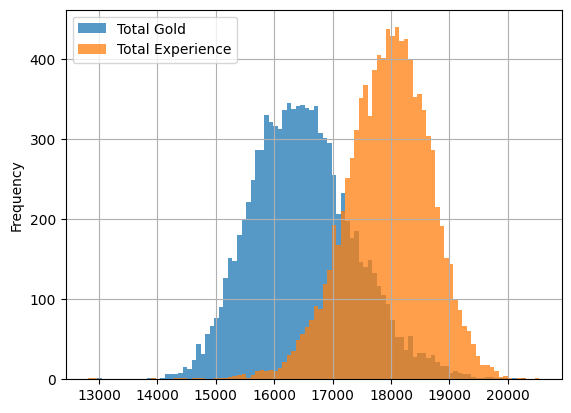

In [106]:
TotalGold = ((df['blueTotalGold'] + df['redTotalGold']) / 2)
TotalExperience = ((df['blueTotalExperience'] + df['redTotalExperience']) / 2)
graph = pd.DataFrame({'Total Gold' : TotalGold, 'Total Experience' : TotalExperience})
graph.plot(kind='hist', grid=True, alpha=0.75, bins = 100)

## Average Level at 10 Minutes

In [107]:
# This describes the number of games where blue won, depending on if they drew first blood or not
# Team gets first blood
blueGreaterAvgLevel = df['blueWins'].astype(bool).where(df['blueExperienceDiff'] > 0)
redGreaterAvgLevel = df['blueWins'].astype(bool).where(df['redExperienceDiff'] > 0)
for i in range(len(blueGreaterAvgLevel)):
	blueGreaterAvgLevel[i] = True if blueGreaterAvgLevel[i] > 0 else False

for i in range(len(redGreaterAvgLevel)):
	redGreaterAvgLevel[i] = True if redGreaterAvgLevel[i] > 0 else False

# Calculate winrate for games where they had more gold
blueGreaterAvgLevelWinrate : float = blueGreaterAvgLevel.value_counts()[True] / blueGreaterAvgLevel.count()
redGreaterAvgLevelWinrate : float = redGreaterAvgLevel.value_counts()[False] / redGreaterAvgLevel.count()
greaterAvgLevelWinrate : float = (blueGreaterAvgLevelWinrate + redGreaterAvgLevelWinrate) / 2
print(greaterAvgLevelWinrate)

0.6025913554003441


Above, we can see that the team that has a higher average level at 10 minutes has a higher winrate by about 8.93%.
Getting ahead early has a substantial impact on the game's outcome.
We should see the same trend with cs at 10 mins as well.

Gold Difference On Win: 1253.892366437869
Experience Difference On Win: 940.0867058397275


<Axes: ylabel='Gold or Experience Difference'>

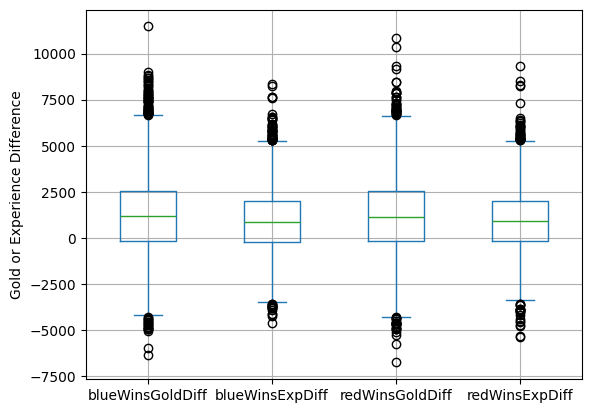

In [108]:
blueWinsGoldDiff = df['blueGoldDiff'].where(df['blueWins'].astype(bool))
blueWinsExpDiff = df['blueExperienceDiff'].where(df['blueWins'].astype(bool))
redWinsGoldDiff = df['redGoldDiff'].where(df['blueWins'].astype(bool) == False)
redWinsExpDiff = df['redExperienceDiff'].where(df['blueWins'].astype(bool) == False)

graph = pd.DataFrame({'blueWinsGoldDiff' : blueWinsGoldDiff, 'blueWinsExpDiff' : blueWinsExpDiff, 'redWinsGoldDiff' : redWinsGoldDiff, 'redWinsExpDiff' : redWinsExpDiff})

print('Gold Difference On Win:', (blueWinsGoldDiff.mean() + redWinsGoldDiff.mean()) / 2)
print('Experience Difference On Win:', (blueWinsExpDiff.mean() + redWinsExpDiff.mean()) / 2)

graph.plot(kind='box', grid=True, ylabel='Gold or Experience Difference')

Slope: 0.6831520066276612
Y-intercept: 40.18085460448049


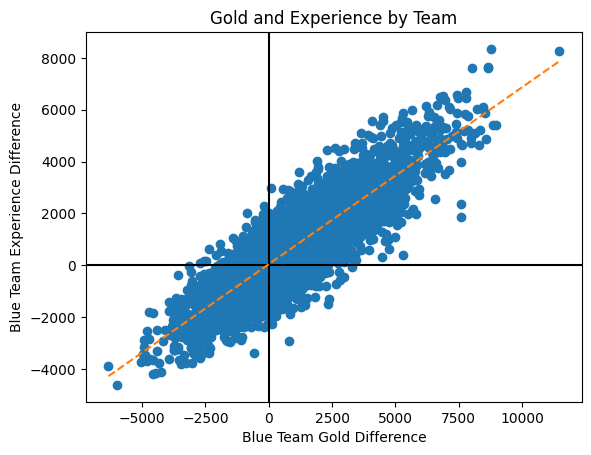

In [109]:
graph = df[['blueGoldDiff','blueExperienceDiff']].where(df['blueWins'].astype(bool)).sort_values('blueGoldDiff')
xs = graph['blueGoldDiff']
ys = graph['blueExperienceDiff']

plt.scatter(xs, ys)
plt.xlabel('Blue Team Gold Difference')
plt.ylabel('Blue Team Experience Difference')
plt.title('Gold and Experience by Team')

m, b = best_fit_line(xs, ys)

print('Slope:', m)
print('Y-intercept:', b)

regression_line = [(m*x)+b for x in xs]
plt.axhline(0, color='k')
plt.axvline(0, color='k')
plt.plot(xs, regression_line, 'C1--')
plt.show()

Slope: 0.43264242026584365
Y-intercept: 10986.809423043374


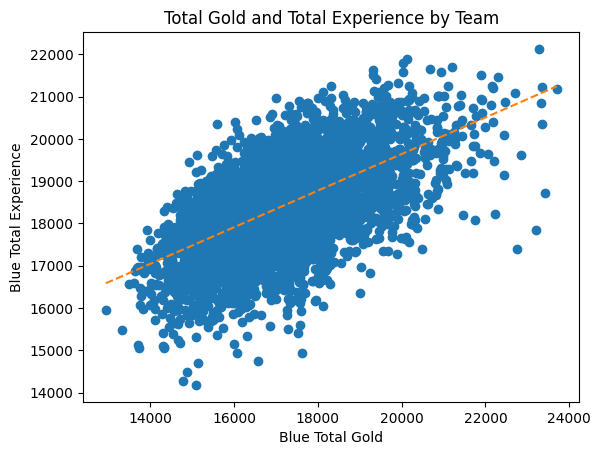

In [110]:
graph = df[['blueTotalGold','blueTotalExperience']].where(df['blueWins'].astype(bool)).sort_values('blueTotalGold')
xs = graph['blueTotalGold']
ys = graph['blueTotalExperience']

plt.scatter(xs, ys)
plt.xlabel('Blue Total Gold')
plt.ylabel('Blue Total Experience')
plt.title('Total Gold and Total Experience by Team')

m, b = best_fit_line(xs, ys)

print('Slope:', m)
print('Y-intercept:', b)

regression_line = [(m*x)+b for x in xs]
plt.plot(xs, regression_line, 'C1--')
plt.show()

## Vision

In [111]:
# This describes the number of games where blue won, depending on if they drew first blood or not
# Team gets first blood
blueVS = df['blueWardsPlaced'] + df['blueWardsDestroyed']
redVS = df['redWardsPlaced'] + df['redWardsDestroyed']
blueVisionScore = df['blueWins'].astype(bool).where(blueVS > redVS)
redVisionScore = df['blueWins'].astype(bool).where(blueVS < redVS)

# Calculate winrate for games where they had more gold
blueGreaterVSWinrate : float = blueVisionScore.value_counts()[True] / blueVisionScore.count()
redGreaterVSWinrate : float = redVisionScore.value_counts()[False] / redVisionScore.count()
greaterVSWinrate : float = (blueGreaterVSWinrate + redGreaterVSWinrate) / 2
print(greaterVSWinrate)

0.5417791568037873


## Elite Monsters (Dragons, Heralds)

Games where a team gets more dragons; because the second dragon spawns after the 10 minute mark, this also indicates the winrate for games where a team gets the *first* dragon.

In [112]:
# This describes the number of games where blue won, depending on if they drew first blood or not
# Team gets first blood
blueDragon = df['blueWins'].astype(bool).where(df['blueDragons'] > df['redDragons'])
redDragon = df['blueWins'].astype(bool).where(df['blueDragons'] < df['redDragons'])

# Calculate winrate for games where they had more gold
blueAssistWinrate : float = blueDragon.value_counts()[True] / blueDragon.count()
redAssistWinrate : float = redDragon.value_counts()[False] / redDragon.count()
moreFirstDragonsWinrate : float = (blueAssistWinrate + redAssistWinrate) / 2
print(moreFirstDragonsWinrate)

0.633383300250465


# Kills

In [113]:
# This describes the number of games where blue won, depending on if they drew first blood or not
# Team gets first blood
blueKills = df['blueWins'].astype(bool).where(df['blueKills'] > df['redKills'])
redKills = df['blueWins'].astype(bool).where(df['blueKills'] < df['redKills'])

# Calculate winrate for games where they had more gold
blueKillWinrate : float = blueKills.value_counts()[True] / blueKills.count()
redKillWinrate : float = redKills.value_counts()[False] / redKills.count()
moreKills : float = (blueKillWinrate + redKillWinrate) / 2
print(moreKills)

0.7263859290056938


# Assists

In [114]:
# This describes the number of games where blue won, depending on if they drew first blood or not
# Team gets first blood
blueAssists = df['blueWins'].astype(bool).where(df['blueAssists'] > df['redAssists'])
redAssists = df['blueWins'].astype(bool).where(df['blueAssists'] < df['redAssists'])

# Calculate winrate for games where they had more gold
blueAssistWinrate : float = blueAssists.value_counts()[True] / blueAssists.count()
redAssistWinrate : float = redAssists.value_counts()[False] / redAssists.count()
moreAssists : float = (blueAssistWinrate + redAssistWinrate) / 2
print(moreAssists)

0.6765005066056533


# Deaths

In [115]:
# This describes the number of games where blue won, depending on if they drew first blood or not
# Team gets first blood
blueDeaths = df['blueWins'].astype(bool).where(df['blueDeaths'] > df['redDeaths'])
redDeaths = df['blueWins'].astype(bool).where(df['blueDeaths'] < df['redDeaths'])

# Calculate winrate for games where they had more gold
blueDeathWinrate : float = blueDeaths.value_counts()[True] / blueDeaths.count()
redDeathWinrate : float = redDeaths.value_counts()[False] / redDeaths.count()
moreDeaths : float = (blueDeathWinrate + redDeathWinrate) / 2
print(moreDeaths)

0.27361407099430635


array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

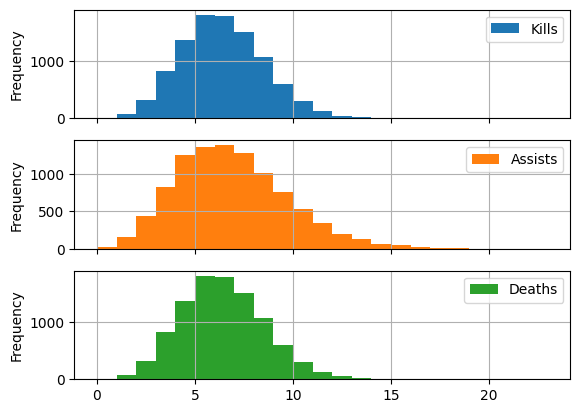

In [116]:
Kills = ((df['blueKills'] + df['redKills']) / 2)
Assists = ((df['blueAssists'] + df['redAssists']) / 2)
Deaths = ((df['blueDeaths'] + df['redDeaths']) / 2)
graph = pd.DataFrame({'Kills' : Kills, 'Assists' : Assists, 'Deaths' : Deaths})
graph.plot(kind='hist', grid=True, subplots=True, bins=23)

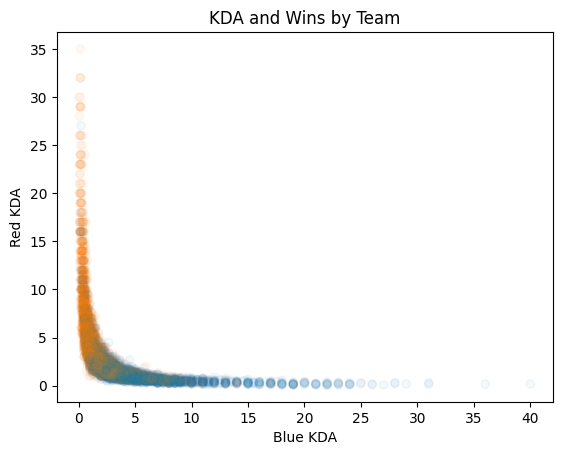

In [138]:
blueKDA = (df['blueKills'] + df['blueAssists']) / df['blueDeaths']
redKDA = (df['redKills'] + df['redAssists']) / df['redDeaths']

my_colors = []
for row in df['blueWins']:
	my_colors.append('C0' if row==True else 'C1')

plt.scatter(blueKDA, redKDA, c=my_colors, alpha=0.05)
plt.xlabel('Blue KDA')
plt.ylabel('Red KDA')
plt.title('KDA and Wins by Team')

plt.show()

<Axes: title={'center': 'Effects of Different Metrics on Winrate'}, ylabel='Winrate'>

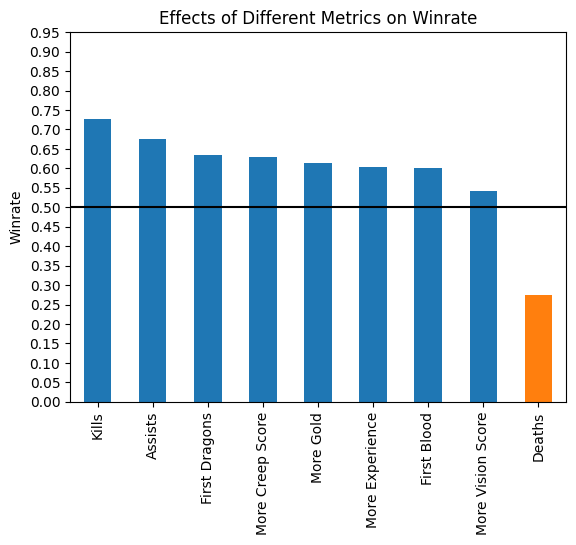

In [121]:
# Graph of experience, gold, creep score, vision score, and elite monsters
graph = pd.Series({'First Blood' : firstBloodWinrate,
				   'More Gold' : moreGoldWinrate,
				   'More Experience' : greaterAvgLevelWinrate,
				   'More Creep Score' : moreCSWinrate,
				   'More Vision Score' : greaterVSWinrate,
				   'First Dragons' : moreFirstDragonsWinrate,
				   'Kills' : moreKills,
				   'Assists' : moreAssists,
				   'Deaths' : moreDeaths})
graph = graph.sort_values(ascending=False)
plt.axhline(0.5, color='k')

my_colors = []
for bar in graph:
	my_colors.append('C0' if bar >= 0.5 else 'C1')

ticks = [x / 20.0 for x in range(0, 20, 1)]

graph.plot(kind='bar', ylabel='Winrate', yticks=ticks, title='Effects of Different Metrics on Winrate', color=my_colors)